# GDP-12 멋진 챗봇 만들기


* 번역 모델을 활용 한 챗봇을 만듭니다 

In [2]:
import os

os.chdir('/content/drive/MyDrive/AIFFEL/mkdir/transformer_chatbot/data')

# 루브릭 평가 기준


| 평가문항 | 상세기준 |
| --- | --- |
| 1. 챗봇 훈련데이터 전처리 과정이 체계적으로 진행되었는가? | 챗봇 훈련데이터를 위한 전처리와 augmentation이 적절히 수행되어 3만개 가량의 훈련데이터셋이 구축되었다. |
| 2. transformer 모델을 활용한 챗봇 모델이 과적합을 피해 안정적으로 훈련되었는가? | 과적합을 피할 수 있는 하이퍼파라미터 셋이 적절히 제시되었다. |
| 3. 챗봇이 사용자의 질문에 그럴듯한 형태로 답하는 사례가 있는가? | 주어진 예문을 포함하여 챗봇에 던진 질문에 적절히 답하는 사례가 제출되었다. |

\\

-----

# 1. 데이터 및 라이브러리 불러오기

- 프로젝트 진행에 필요한 라이브러리와 데이터를 불러옵니다.

In [3]:
#sentencepiece 설치 
! pip install sentencepiece

     |████████████████████████████████| 1.2 MB 15.8 MB/s 


In [4]:
# konlpy, Mecab 형태소 분석기 설치 스크립트 실행
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash


--2022-04-15 09:24:44--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2022-04-15 09:24:44--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb42506c40aa64aacc6e267c86a.dl.dropboxusercontent.com/cd/0/get/BjaZY41SagNfqfYpBR2LJk8h0g3QrHaNC0s9xvAYucVBjE-Dm8ng5W7D1Rjnsv41-_wuitTwzk6x-Qo_UtfEUgFmpO6gVDAGLe-eoObsxD_F7GjekUJi0BdbQ4cttGtXKnaOFJv2CooeAfc0pf1NH6Y8XcjnTLLJRZEUtSmS9PNe0V2p620yKp6tCIzKyTbbUdQ/file?dl=1# [following]
--2022-04-15 09:24:44--  https://ucb42506c40aa64aacc6e267c86a.dl.dropboxusercontent.com/cd/0/g

## &nbsp;&nbsp; 1-1 라이브러리 불러오기

In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf

import re
import os
import io
import time
import random

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from nltk.translate.bleu_score import SmoothingFunction
from nltk.translate.bleu_score import sentence_bleu
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
from collections import Counter
from konlpy.tag import Mecab

\\

## &nbsp;&nbsp; 1-2 데이터 불러오기


한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용합니다.

이 데이터는 아래의 링크에서 다운로드할 수 있습니다.

- [songys/Chatbot_data](https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv)


In [38]:
file_path = '/content/drive/MyDrive/AIFFEL/mkdir/transformer_chatbot/data/ChatbotData .csv'

data = pd.read_csv(file_path)
data

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


- 읽어 온 데이터의 질문과 답변을 각각 questions, answers 변수에 나눠서 저장합니다.

In [44]:
# zip 으로 순서를 묶어줌 
src = []
tgt = []
for s, t in zip(data['Q'], data['A']):
    src.append(str(s))
    tgt.append(str(t))


In [45]:
print('Q: ', src[0], '\n','Q 총 길이: ', len(src))
print('A: ', tgt[0], '\n','A 총 길이: ', len(tgt))

Q:  12시 땡! 
 Q 총 길이:  11823
A:  하루가 또 가네요. 
 A 총 길이:  11823


\\

-----

# 2. 데이터 정제

아래 조건을 만족하는 `preprocess_sentence()` 함수를 구현하세요.

1. 영문자의 경우, **모두 소문자로 변환**합니다.
2. 영문자와 한글, 숫자, 그리고 주요 특수문자를 제외하곤 **정규식을 활용하여 모두 제거**합니다.

*문장부호 양옆에 공백을 추가하는 등 이전과 다르게 생략된 기능들은 우리가 사용할 토크나이저가 지원하기 때문에 굳이 구현하지 않아도 괜찮습니다!*

In [46]:
mecab = Mecab()

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^0-9ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()
    corpus = mecab.morphs(sentence)
    
    return corpus



\\

-----

# 3.  데이터 토큰화

토큰화에는 *KoNLPy*의 `mecab` 클래스를 사용합니다.

아래 조건을 만족하는 `build_corpus()` 함수를 구현하세요!

1. **소스 문장 데이터**와 **타겟 문장 데이터**를 입력으로 받습니다.
2. 데이터를 앞서 정의한 `preprocess_sentence()` 함수로 **정제하고, 토큰화**합니다.
3. 토큰화는 **전달받은 토크나이즈 함수를 사용**합니다. 이번엔 `mecab.morphs` 함수를 전달하시면 됩니다.
4. 토큰의 개수가 일정 길이 이상인 문장은 **데이터에서 제외**합니다.
5. **중복되는 문장은 데이터에서 제외**합니다. `소스 : 타겟` 쌍을 비교하지 않고 소스는 소스대로 타겟은 타겟대로 검사합니다. 중복 쌍이 흐트러지지 않도록 유의하세요!

구현한 함수를 활용하여 `questions` 와 `answers` 를 각각 `que_corpus` , `ans_corpus` 에 토큰화하여 저장합니다.

In [47]:
# 순서 묶어주고 중복 제거해서 list화 
cleaned_corpus = list(set(zip(src,tgt)))

In [48]:
cleaned_corpus [:3]

[('구박하면서 엄청 일 시켜', '일을 몰라서 그런가봐요.'),
 ('헤어질때의 모습이 그 사람의 진짜 모습', '그 모습도 그 사람의 부분이에요.'),
 ('시골 내려가서 살까', '아무래도 덜 경쟁하겠죠.')]

In [49]:
src_corpus = []
tgt_corpus = []


for tmp in cleaned_corpus:
    #print(tmp[0])
    #print(tmp[1])
    tmp_src = preprocess_sentence(tmp[0])
    tmp_tgt = preprocess_sentence(tmp[1])
    #if len(tmp_ko) <= 40:
    src_corpus.append(tmp_src)
    tgt_corpus.append(tmp_tgt)

    
que_corpus = src_corpus
ans_corpus = tgt_corpus    


print(len(src_corpus))
print(len(tgt_corpus))
print("Questions", src_corpus[0])   
print("Answers:", tgt_corpus[0])

11750
11750
Questions ['구박', '하', '면서', '엄청', '일', '시켜']
Answers: ['일', '을', '몰라서', '그런가', '봐요', '.']


\\

-----

# 4. Augmentation

우리에게 주어진 데이터는 **1만 개가량으로 적은 편**에 속합니다. 이럴 때에 사용할 수 있는 테크닉을 배웠으니 활용해 봐야겠죠? **Lexical Substitution을 실제로 적용**해 보도록 하겠습니다.

아래 링크를 참고하여 **한국어로 사전 훈련된 Embedding 모델을 다운로드**합니다. `Korean (w)` 가 Word2Vec으로 학습한 모델이며 용량도 적당하므로 사이트에서 `Korean (w)`를 찾아 다운로드하고, `ko.bin` 파일을 얻으세요!

- [Kyubyong/wordvectors](https://github.com/Kyubyong/wordvectors)

다운로드한 모델을 활용해 **데이터를 Augmentation** 하세요! 앞서 정의한 `lexical_sub()` 함수를 참고하면 도움이 많이 될 겁니다.

*Augmentation된 `que_corpus` 와 원본 `ans_corpus` 가 병렬을 이루도록, 이후엔 반대로 원본 `que_corpus` 와 Augmentation된 `ans_corpus` 가 병렬을 이루도록 하여 **전체 데이터가 원래의 3배가량으로 늘어나도록** 합니다.*

- ko.bin 가져오기 

In [51]:
#gensim 버전 확인 
print(gensim.__version__)

3.6.0


In [52]:
word2vec_path = 'ko.bin'
word2vec = Word2Vec.load(word2vec_path)

In [54]:
word2vec.similar_by_word("학교")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('학교의', 0.7560996413230896),
 ('강습소', 0.7425637245178223),
 ('중고등학교', 0.7386142015457153),
 ('전문학교', 0.7356827855110168),
 ('사립학교', 0.7347193956375122),
 ('소학교', 0.7305554747581482),
 ('여학교', 0.7091007232666016),
 ('사범학교', 0.6901223659515381),
 ('대학', 0.6897724866867065),
 ('학원', 0.6869212985038757)]

## &nbsp;&nbsp; Lexical Substitution 구현하기

입력된 문장을 Embedding 유사도를 기반으로 Augmentation 하여 반환하는 lexical_sub() 를 구현합니다.

In [58]:
def lexical_sub(sentence, word2vec):
    res = ""
    toks = sentence

    try:
        _from = random.choice(toks)
        _to = word2vec.most_similar(_from)[0][0]
        
    except:   # 단어장에 없는 단어
        return None

    for tok in toks:
        if tok is _from: res += _to + " "
        else: res += tok + " "

    return res

In [61]:
print(que_corpus[1])
print(lexical_sub(que_corpus[1], word2vec))

['헤어질', '때', '의', '모습', '이', '그', '사람', '의', '진짜', '모습']
헤어질 때 의 모습 이 그 사람 의 진짜 광경 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  import sys


In [62]:
new_que_corpus = []
new_ans_corpus = []

# Augmentation된 que_corpus 와 원본 ans_corpus 가 병렬을 이루도록 한다.
for idx in tqdm_notebook(range(len(que_corpus))):
    que_augmented = lexical_sub(que_corpus[idx], word2vec)
    ans = ans_corpus[idx]
    
    if que_augmented is not None:
        new_que_corpus.append(que_augmented.split())
        new_ans_corpus.append(ans)
        
    else:
       
        continue
    
for idx in tqdm_notebook(range(len(ans_corpus))):
    que = que_corpus[idx]
    ans_augmented = lexical_sub(ans_corpus[idx], word2vec)
    
    if ans_augmented is not None:
        new_que_corpus.append(que)
        new_ans_corpus.append(ans_augmented.split())
       
    else:
       
        continue

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/11750 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/11750 [00:00<?, ?it/s]

In [63]:
print(new_que_corpus[:3])
print(new_ans_corpus[:3])
print('-'*80)
print(len(new_que_corpus))
print(len(new_ans_corpus))

[['구박', '하', '면서', '굉장히', '일', '시켜'], ['헤어질', '때쯤', '의', '모습', '이', '그', '사람', '의', '진짜', '모습'], ['시골', '올라가', '서', '살까']]
[['일', '을', '몰라서', '그런가', '봐요', '.'], ['그', '모습', '도', '그', '사람', '의', '부분', '이', '에요', '.'], ['아무래도', '덜', '경쟁', '하', '겠', '죠', '.']]
--------------------------------------------------------------------------------
20333
20333


\\

-----

# 5. 데이터 벡터화

- 타겟 데이터인 ans_corpus 에 <start> 토큰과 <end> 토큰이 추가되지 않은 상태이니 이를 먼저 해결한 후 벡터화를 진행합니다. 
```python
sample_data = ["12", "시", "땡", "!"]
print(["<start>"] + sample_data + ["<end>"])
```

- 위 소스를 참고하여 타겟 데이터 전체에 `<start>` 토큰과 `<end>` 토큰을 추가해 주세요!

- 챗봇 훈련 데이터의 가장 큰 특징 중 하나라고 하자면 바로 **소스 데이터와 타겟 데이터가 같은 언어를 사용한다는 것**이겠죠. 앞서 배운 것처럼 이는 Embedding 층을 공유했을 때 많은 이점을 얻을 수 있습니다.

- 특수 토큰을 더함으로써 `ans_corpus` 또한 완성이 되었으니, `que_corpus` 와 결합하여 **전체 데이터에 대한 단어 사전을 구축**하고 **벡터화하여 `enc_train` 과 `dec_train`** 을 얻으세요!

In [64]:
tgt_corpus = []

for corpus in ans_corpus:
    tgt_corpus.append(["<start>"] + corpus + ["<end>"])
    
print(tgt_corpus[0])
print(tgt_corpus[325])
print(tgt_corpus[395])
ans_corpus = tgt_corpus

['<start>', '일', '을', '몰라서', '그런가', '봐요', '.', '<end>']
['<start>', '저', '도', '알려', '주', '세요', '.', '<end>']
['<start>', '피할', '수', '있', '으면', '피하', '고', '싶', '은', '사람', '이', '네요', '.', '<end>']


In [65]:
voc_data = que_corpus + ans_corpus

words = np.concatenate(voc_data).tolist()
counter = Counter(words)
counter = counter.most_common(30000-2)
vocab = ['<pad>', '<unk>'] + [key for key, _ in counter]
word_to_index = {word:index for index, word in enumerate(vocab)}
index_to_word = {index:word for word, index in word_to_index.items()}


In [68]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index[word] if word in word_to_index else word_to_index['<unk>'] for word in sentence]

def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<unk>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

def vectorize(corpus, word_to_index):
    data = []
    for sen in corpus:
        sen = get_encoded_sentence(sen, word_to_index)
        data.append(sen)
    return data

que_train = vectorize(que_corpus, word_to_index)
ans_train = vectorize(ans_corpus, word_to_index)

print(len(que_train))
print(len(ans_train))

11750
11750


In [70]:

enc_tensor = tf.keras.preprocessing.sequence.pad_sequences(que_train, padding='post')
dec_tensor = tf.keras.preprocessing.sequence.pad_sequences(ans_train, padding='post')

# train, test split
enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.01) # test set은 1%만

print(len(enc_train))
print(len(enc_val)) 
print(len(dec_train))
print(len(dec_val))

11632
118
11632
118


\\

-----

# 6. 모델링 & 훈련하기

- 모델은 예제에서 만들었던 방법 대로 만들어 줍니다. 

앞서 번역 모델을 훈련하며 정의한 Transformer 를 그대로 사용하시면 됩니다! 대신 데이터의 크기가 작으니 하이퍼파라미터를 튜닝해야 과적합을 피할 수 있습니다. 모델을 훈련하고 아래 예문에 대한 답변을 생성하세요! 가장 멋진 답변과 모델의 하이퍼파라미터를 제출하시면 됩니다.

## &nbsp;&nbsp; 모델링 

- 예제에서 만들었던거 그대로 가져옵니다.

In [71]:
# Positional Encoding 구현
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # 인덱스가 짝수
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # 인덱스가 홀수

             
    return sinusoid_table

In [72]:
# Mask  생성하기
def generate_padding_mask(seq):
    # tf.math.equal: seq의 원소가 0이 되면 true로 반환, 아니면 false 반환
    # tf.cast: true를 float32로 변환
    
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]    # np.newaxis: numpy array의 차원 늘려주기

def generate_causality_mask(src_len, tgt_len):
    # np.cumsum(): 배열에서 행에 따라 누적되는 원소들의 누적합 계산
    # np.eye(): 대각선이 1인 seq_len x seq_len 크기의 대각행렬 생성
    
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)  # tf.cast: mask(텐서)를 float32로 변환


def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [73]:
# Multi Head Attention 구현
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads
        
        # Linear Layer
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)   #  Scaled QK

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)   # Attention Weights
        out = tf.matmul(attentions, V)

        return out, attentions


    def split_heads(self, x):
        bsz = x.shape[0]  # batch size
        # reshape - shape의 한 원소만 -1, 의미는 전체 크기가 일정하게 유지되도록 해당 차원의 길이가 자동으로 계산
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])   #  perm은 치환하는 위치를 알려줌

        return split_x

    
    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x


    def call(self, Q, K, V, mask):
        # Linear 레이어 추가 - embedding 매핑
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)

        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

In [74]:
# Position-wise Feed Forward Network 구현
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)

        return out

In [75]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, enc_attn

In [76]:
# Decoder 레이어 구현
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.dec_self_attn(out, enc_out, enc_out, causality_mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [77]:
# Encoder 구현
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):
        out = x

        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)

        return out, enc_attns

In [78]:
# Decoder 구현
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]


    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x

        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [79]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,  # 레이어의 차원수
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
    
        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
  
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        # np.newaxis: numpy array의 차원 늘려주기
        
        out = self.do(out)

        return out


    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

In [81]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()

        self.d_model = d_model
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)

        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [82]:
# Learning Rate 인스턴스 선언
learning_rate = LearningRateScheduler(d_model)

# Optimizer 구현
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)



In [83]:
# Loss Function 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [84]:
# Train Step 정의
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [80]:
# 주어진 하이퍼파라미터로 Transformer 인스턴스 생성
transformer = Transformer(
    n_layers=4,
    d_model=128,
    n_heads=8,
    d_ff=256,
    src_vocab_size=50000,ㄴ
    tgt_vocab_size=50000,
    pos_len=42,
    dropout=0.3,
    shared_fc=True,
    shared_emb=True)

d_model = 128

## &nbsp;&nbsp; 모델 훈련하기 

In [85]:
def evaluate(sentence, model):
    # sentence 전처리(enc_train과 같은 모양으로)
    sentence = preprocess_sentence(sentence)
    pieces = sentence
    tokens = get_encoded_sentence(pieces, word_to_index)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    
    output = tf.expand_dims([word_to_index["<start>"]], 0) 
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()
        
        # 예측 단어가 종료 토큰일 경우
        if word_to_index["<end>"] == predicted_id:
            result = get_decoded_sentence(ids, index_to_word)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns
        ##word_to_index
        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = get_decoded_sentence(ids, index_to_word)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

def translate(sentence, model):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    return result

In [86]:
BATCH_SIZE = 64
EPOCHS = 60

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

In [87]:
examples = [
    "지루하다, 놀러가고 싶어.",
    "오늘 일찍 일어났더니 피곤하다.",
    "간만에 여자친구랑 데이트 하기로 했어.",
    "집에 있는다는 소리야."
]

In [88]:
for example in examples:
    translate(example, transformer)

Input: 지루하다, 놀러가고 싶어.
Predicted translation: 라고 생각 해 보 세요 .
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 차리 세요 .
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 실내 데이트 가 중요 해요 .
Input: 집에 있는다는 소리야.
Predicted translation: 님 이 중요 한 편 이 에요 .


# 7. 성능 측정하기 

In [89]:
reference = "자연어 처리에서 트랜스포머는 꼭 자세히 알고 지나가야한다.".split()
candidate = "자 연어 처리의 트랜스포머는 자세히 알고 가야 된다.".split()

print("원문:", reference)
print("번역문:", candidate)
print("BLEU Score:", sentence_bleu([reference], candidate))

원문: ['자연어', '처리에서', '트랜스포머는', '꼭', '자세히', '알고', '지나가야한다.']
번역문: ['자', '연어', '처리의', '트랜스포머는', '자세히', '알고', '가야', '된다.']
BLEU Score: 0.48109772909788073


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [91]:
def calculate_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):
    return sentence_bleu([reference],
                         candidate,
                         weights=weights,
                         smoothing_function=SmoothingFunction().method1)  # smoothing_function 적용

print("BLEU-1:", calculate_bleu(reference, candidate, weights=[1, 0, 0, 0]))
print("BLEU-2:", calculate_bleu(reference, candidate, weights=[0, 1, 0, 0]))
print("BLEU-3:", calculate_bleu(reference, candidate, weights=[0, 0, 1, 0]))
print("BLEU-4:", calculate_bleu(reference, candidate, weights=[0, 0, 0, 1]))

print("\nBLEU-Total:", calculate_bleu(reference, candidate))

BLEU-1: 0.375
BLEU-2: 0.14285714285714285
BLEU-3: 0.01666666666666667
BLEU-4: 0.02

BLEU-Total: 0.06500593260343691


In [92]:
def eval_bleu(src_corpus, tgt_corpus, verbose=True):
    total_score = 0.0
    sample_size = len(tgt_corpus)

    for idx in tqdm_notebook(range(sample_size)):
        src_tokens = src_corpus[idx]
        tgt_tokens = tgt_corpus[idx]
        
        src = []
        tgt = []
        
        for word in src_tokens:
            if word !=0 and word !=1 and word !=3 and word !=4:
                src.append(word)
        
        for word in tgt_tokens:
            if word != 0 and word != 3 and word !=4:
                tgt.append(word)

        src_sentence = get_decoded_sentence(src, index_to_word)
        tgt_sentence = get_decoded_sentence(tgt, index_to_word)
        
        
        reference = preprocess_sentence(tgt_sentence)
        candidate = translate(src_sentence, transformer)

        score = sentence_bleu([reference], candidate,
                              smoothing_function=SmoothingFunction().method1)
        total_score += score

        if verbose:
            print("Source Sentence: ", src_sentence)
            print("Model Prediction: ", candidate)
            print("Real: ", reference)
            print("Score: %lf\n" % score)

    print("Num of Sample:", sample_size)
    print("Total Score:", total_score / sample_size)

In [93]:
eval_bleu(enc_val[::5], dec_val[::5], verbose=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/24 [00:00<?, ?it/s]

Input: 돌아올 거 아 는데
Predicted translation: 를 버려야 덜 다칠 거 예요 .
Source Sentence:  돌아올 거 아 는데
Model Prediction:  를 버려야 덜 다칠 거 예요 .
Real:  ['지', '마세요', '.']
Score: 0.011503

Input: 이 기대 돼
Predicted translation: 함 을 이 네요 .
Source Sentence:  이 기대 돼
Model Prediction:  함 을 이 네요 .
Real:  ['은', '일', '이', '생길', '거', '예요', '.']
Score: 0.025099

Input: 친구 가 집안일 을 너무 안 해 . 나 만 하 는 게 고민 이 야 .
Predicted translation: 조절 이 네요 .
Source Sentence:  친구 가 집안일 을 너무 안 해 . 나 만 하 는 게 고민 이 야 .
Model Prediction:  조절 이 네요 .
Real:  ['을', '하나', '씩', '분담', '해', '보', '세요', '.']
Score: 0.023980

Input: 가 쌓였 네
Predicted translation: 하 세요 .
Source Sentence:  가 쌓였 네
Model Prediction:  하 세요 .
Real:  ['하', '세요', '.']
Score: 0.048549

Input: 입금 됐 다고 문자 왔 어
Predicted translation: 는 너무 잘 부족 했 어요 .
Source Sentence:  입금 됐 다고 문자 왔 어
Model Prediction:  는 너무 잘 부족 했 어요 .
Real:  ['아', '축하', '해요']
Score: 0.000000

Input: 양말 포근포근 따뜻 하 다
Predicted translation: 장 봅니다 .
Source Sentence:  양말 포근포근 따뜻 하 다
Model Prediction:  장 봅니다 .
Real:  ['이', 

\\

-----

# 후기!

- LMS 노드 진행 중, `beam_search_decoder` 부분에서 자꾸 아래와 같은 오류가 발생했다. 해결책을 찾고 싶었지만, 우선 내가 바꾼 코드가 아닌, LMS 노드 상에 있던 코드였고, 에러 메세지가 애매했기 때문에 결국 해결 하지 못하고 넘어갔던 것 같다.. 왜 그런걸까요..?

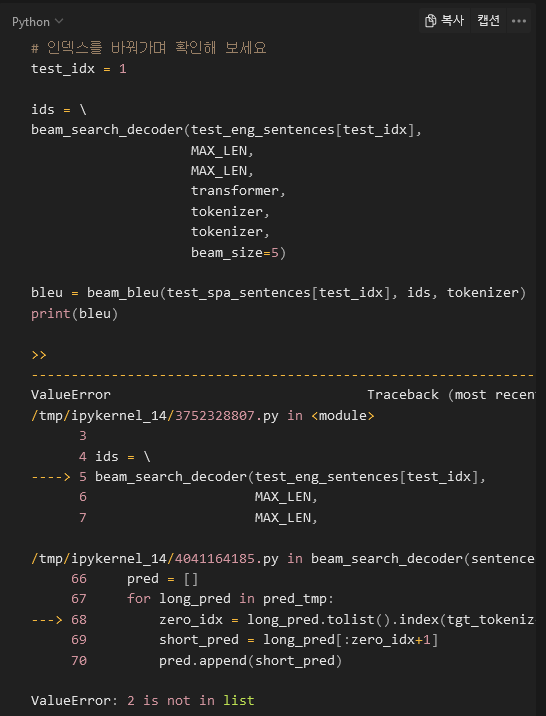

- 데이터 전처리가 너무너무 잘 됬던 걸까.. input 문장도 뭔가 미완성된 문장 느낌이라 이게 맞는건가 싶기도하고...🤔 하지만 충분히 많은 학습이 이루어 진 것도 아니고, 학습 데이터도 그렇게 많았던게 아니여도 이 정도였으니 잘 됬다고 말 해도 되지않을까? ㅎㅎ 

\\

-----

# 🖇 참고페이지


- 노드 진행 관련 
[전진환님 GDP-12 프로젝트](https://github.com/Jeon0866/AIFFEL_GoingDeeper/blob/master/GD12_Transformer_chatbot.ipynb)
